<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.3
# *KNN classification Lab*

**In this lab, we will:**
- Practice KNN classification on a dataset of breast cancer.
- Predict the `diagnoosis` of a patient from predictor variables of your choice.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [15]:
# IMPORT LIBRARIES
from itertools import combinations
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
breast_cancer_csv = '../../DATA/breast-cancer-wisconsin-data.csv'
breast_cancer = pd.read_csv(breast_cancer_csv, index_col='id')

breast_cancer.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                                         
842302           M        17.99         10.38          122.80     1001.0   
842517           M        20.57         17.77          132.90     1326.0   
84300903         M        19.69         21.25          130.00     1203.0   
84348301         M        11.42         20.38           77.58      386.1   
84358402         M        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
id                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  ...  texture_worst  \
id                                            ...                  
842302                0.14710         0.2419  ...          17.33   
842517                0.07017         0.1812  ...          23.41   
84300903              0.12790         0.2069  ...          25.53   
84348301              0.10520         0.2597  ...          26.50   
84358402              0.10430         0.1809  ...          16.67   

          perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
id                                                                           
842302             184.60      2019.0            0.1622             0.6656   
842517             158.80      1956.0            0.1238             0.1866   
84300903           152.50      1709.0            0.1444             0.4245   
84348301            98.87       567.7            0.2098             0.8663   
84358402           152.20      1575.0            0.1374             0.2050   

          concavity_worst  concave points_worst  symmetry_worst  \
id                                                                
842302             0.7119                0.2654          0.4601   
842517             0.2416                0.1860          0.2750   
84300903           0.4504                0.2430          0.3613   
84348301           0.6869                0.2575          0.6638   
84358402           0.4000                0.1625          0.2364   

          fractal_dimension_worst  Unnamed: 32  
id                                              
842302                    0.11890          NaN  
842517                    0.08902          NaN  
84300903                  0.08758          NaN  
84348301                  0.17300          NaN  
84358402                  0.07678          NaN  

[5 rows x 32 columns]

In [17]:
breast_cancer = breast_cancer.drop("Unnamed: 32", axis=1)

### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [18]:
breast_cancer.shape

(569, 31)

In [19]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [20]:
breast_cancer.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  ...  radius_worst  \
count     569.000000              569.000000  ...    569.000000   
mean        0.181162                0.062798  ...     16.269190   
std         0.027414                0.007060  ...      4.833242   
min         0.106000                0.049960  ...      7.930000   
25%         0.161900                0.057700  ...     13.010000   
50%         0.179200                0.061540  ...     14.970000   
75%         0.195700                0.066120  ...     18.790000   
max         0.304000                0.097440  ...     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000          0.222600   

       compactness_worst  concavity_worst  concave points_worst  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 30 columns]

In [21]:
breast_cancer.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [22]:
(breast_cancer['diagnosis'].value_counts(normalize=True) * 100)

B    62.741652
M    37.258348
Name: diagnosis, dtype: float64

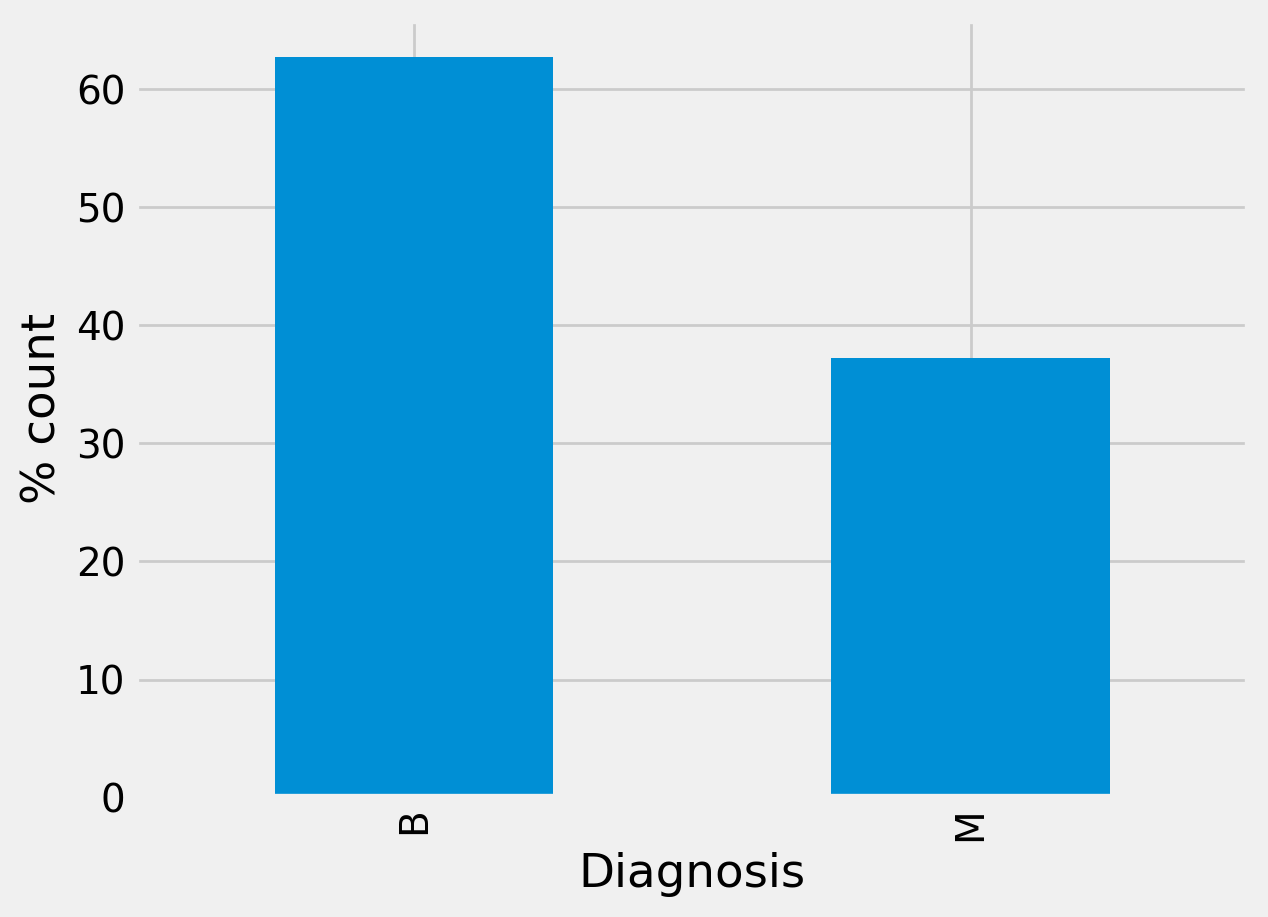

In [23]:
(breast_cancer['diagnosis'].value_counts(normalize=True) * 100).plot(kind='bar')
plt.ylabel('% count')
plt.xlabel('Diagnosis')
plt.show()

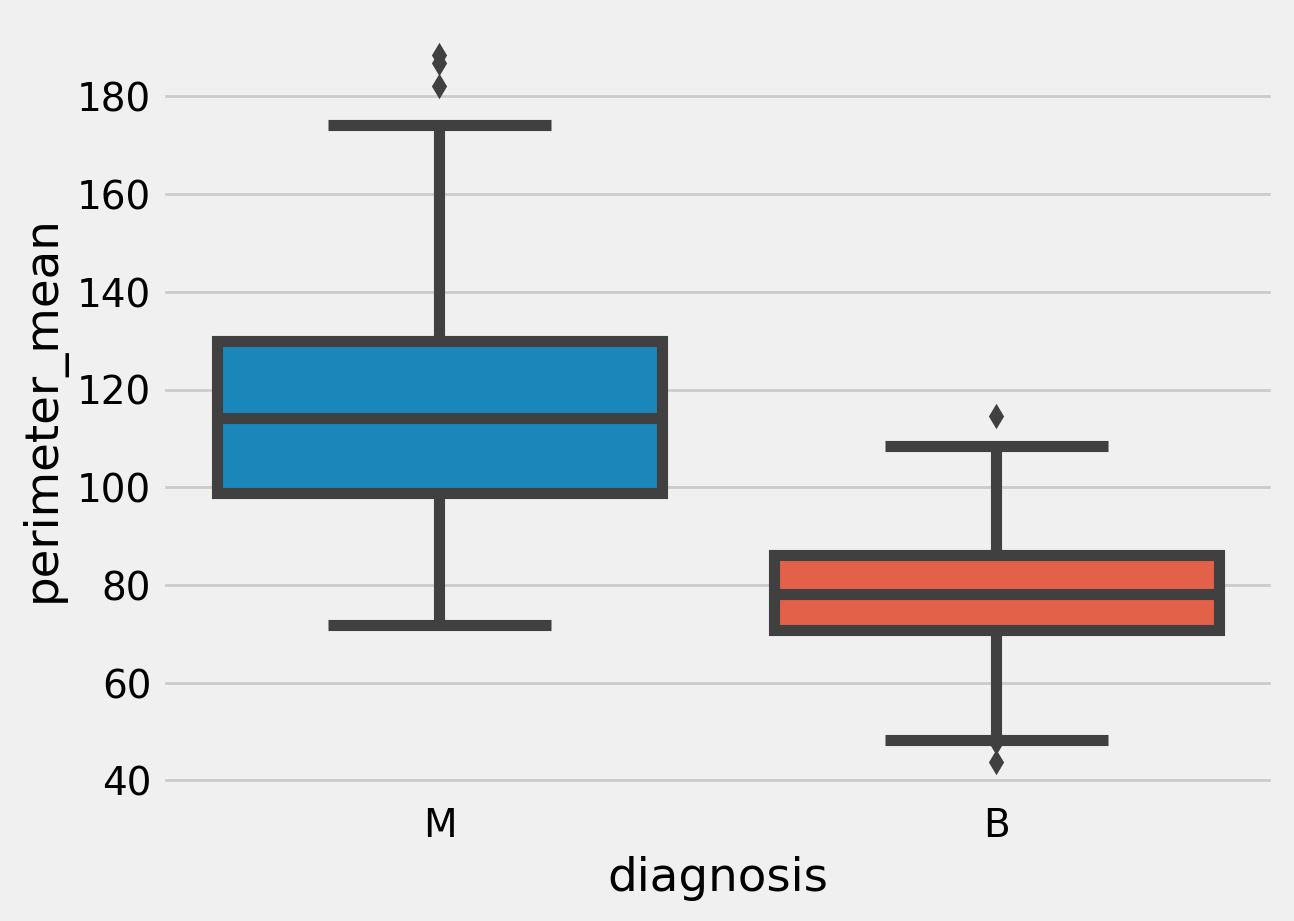

In [25]:
sns.boxplot(x='diagnosis', y='perimeter_mean', data=breast_cancer)
plt.show()

C:\Users\Shivraj\AppData\Local\Temp\ipykernel_7796\2149639963.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(breast_cancer.corr(), dtype=np.bool)


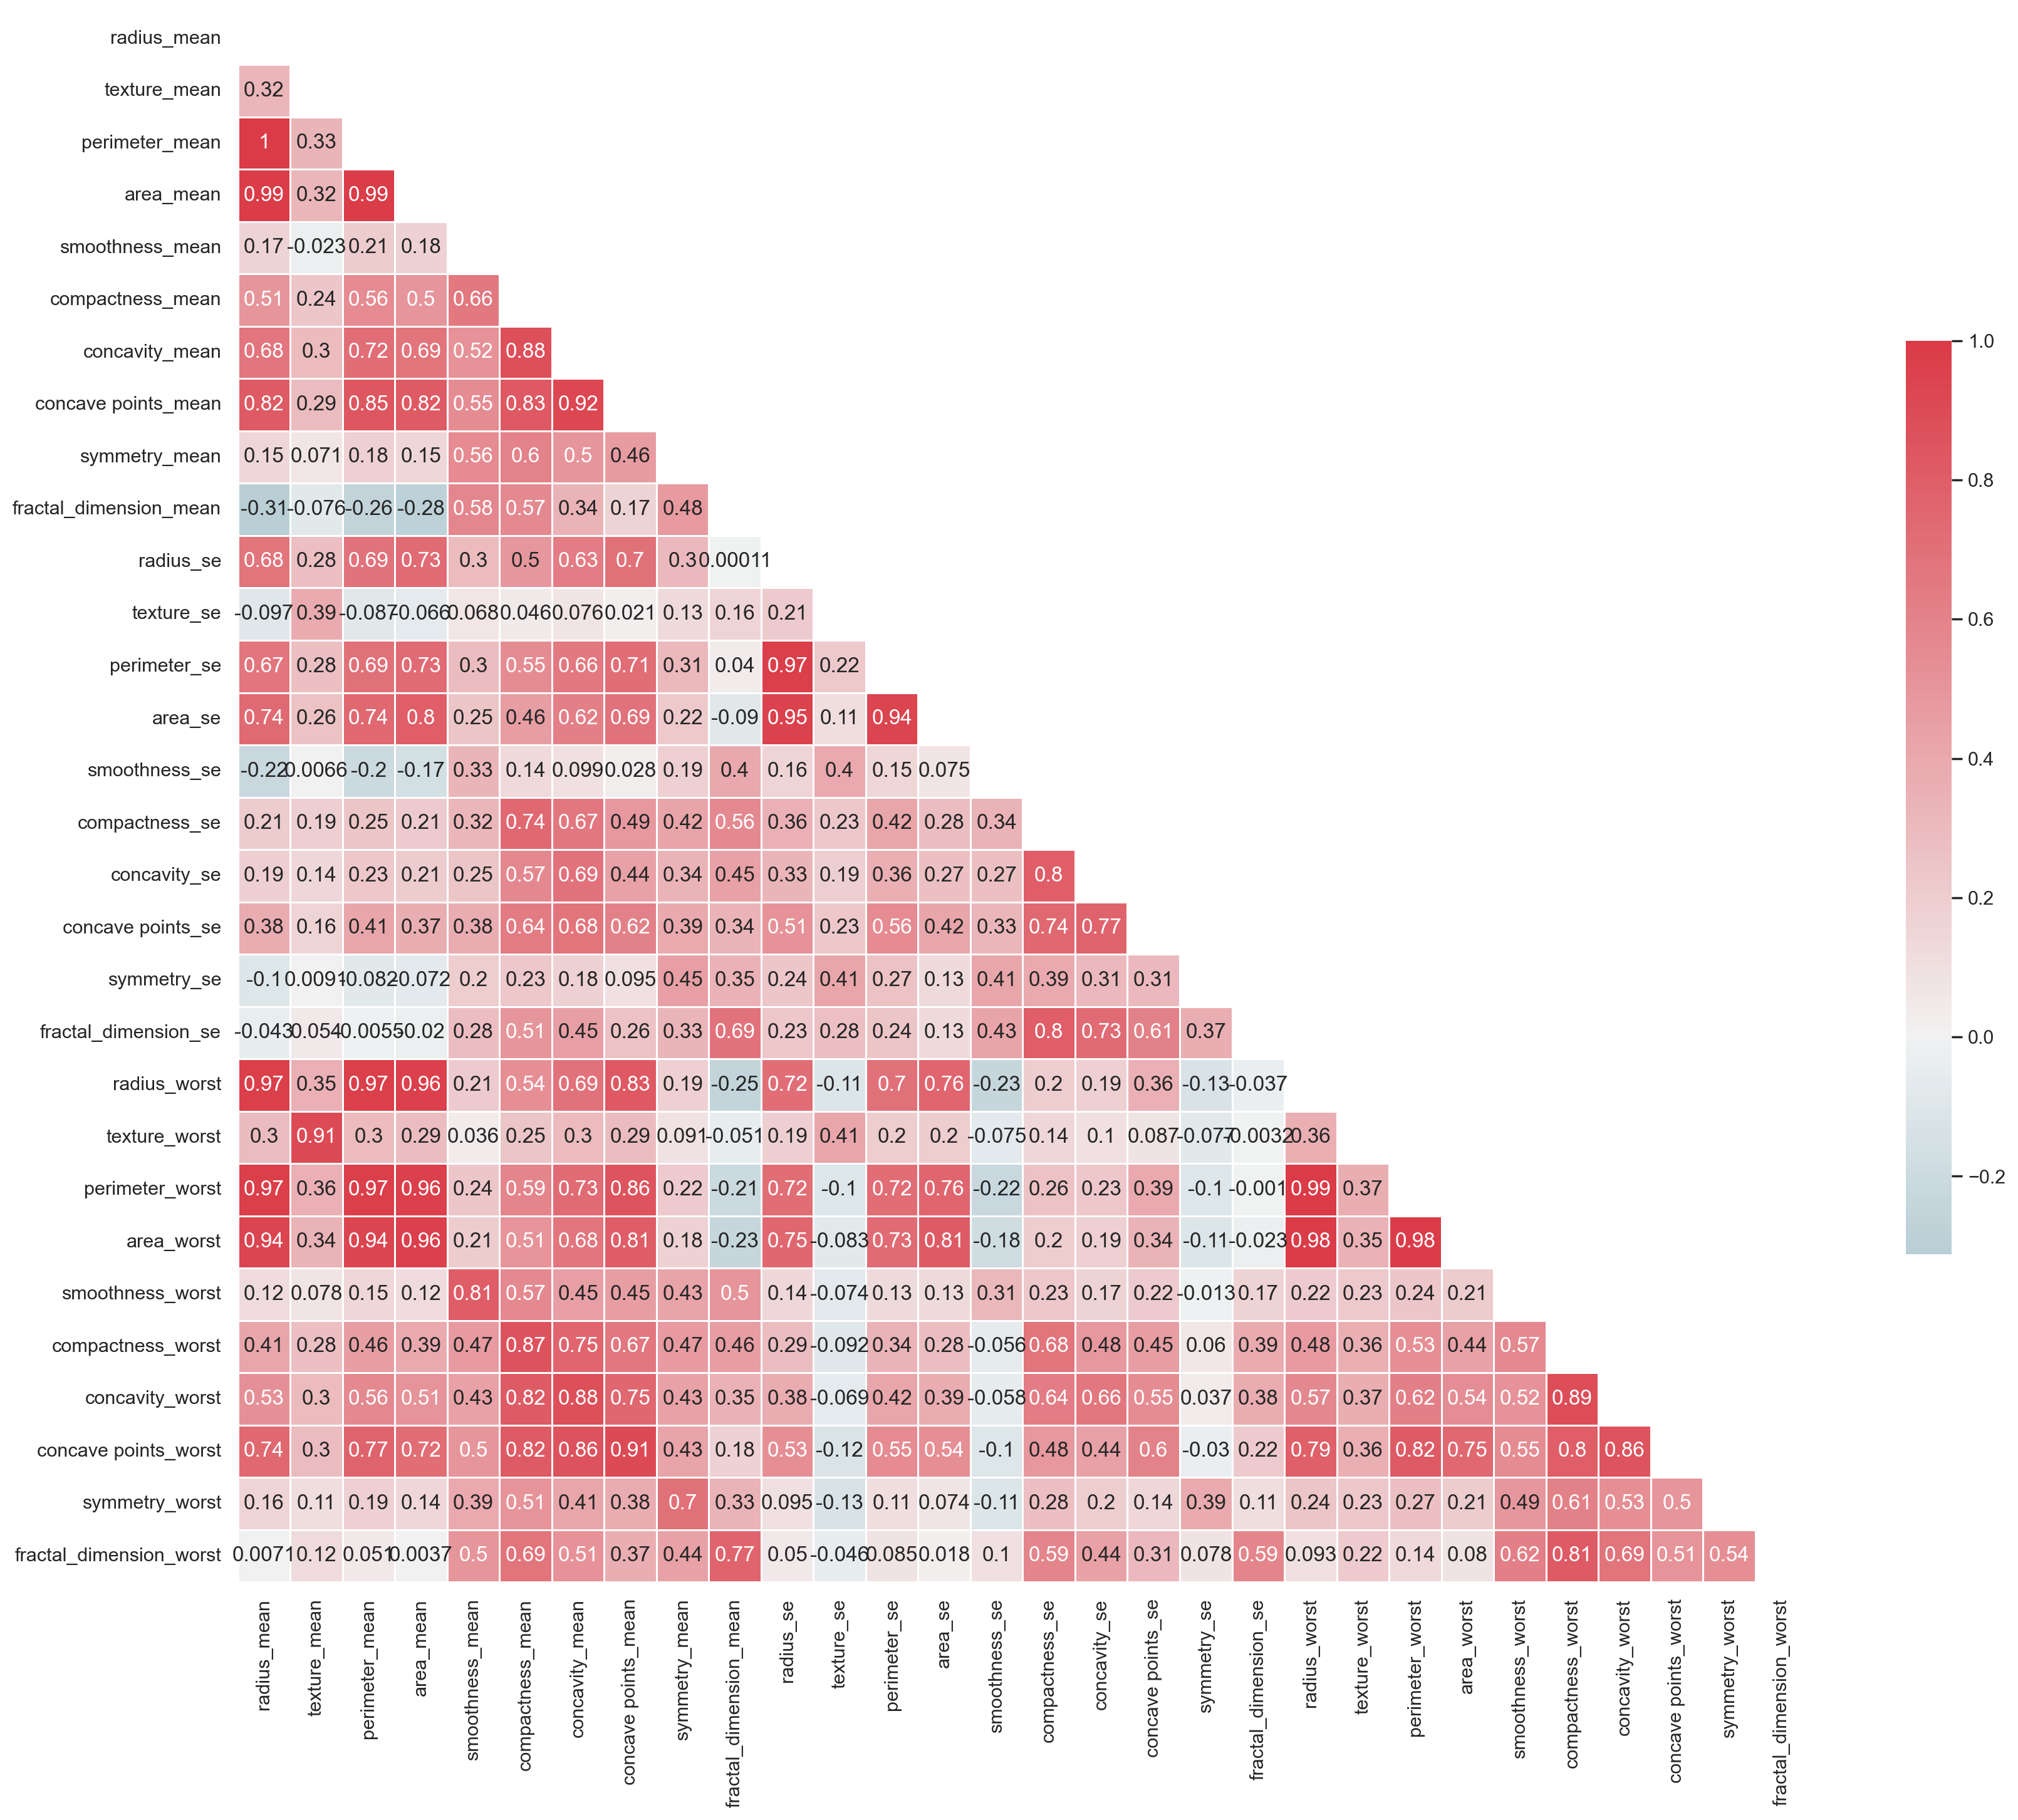

In [27]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(breast_cancer.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(breast_cancer.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

In [28]:
breast_cancer.columns


Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [30]:
mean_only_columns = []

for column in breast_cancer.columns:
    if '_mean' in column or 'diagnosis' in column:
        mean_only_columns.append(column)
        
# List comprehension version: 
# mean_only_columns = [c for c in breast_cancer.columns if not '_worst' in c and not '_se' in c]

print(mean_only_columns)

['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']


In [31]:
selected_breast_cancer = breast_cancer[mean_only_columns]
selected_breast_cancer.head(2)

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                                                                       
842302         M        17.99         10.38           122.8     1001.0   
842517         M        20.57         17.77           132.9     1326.0   

        smoothness_mean  compactness_mean  concavity_mean  \
id                                                          
842302          0.11840           0.27760          0.3001   
842517          0.08474           0.07864          0.0869   

        concave points_mean  symmetry_mean  fractal_dimension_mean  
id                                                                  
842302              0.14710         0.2419                 0.07871  
842517              0.07017         0.1812                 0.05667

In [32]:
def plot_corr_heatmap(df):

    # Copied code from seaborn examples
    # https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(18, 18))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

C:\Users\Shivraj\AppData\Local\Temp\ipykernel_7796\2611514747.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)


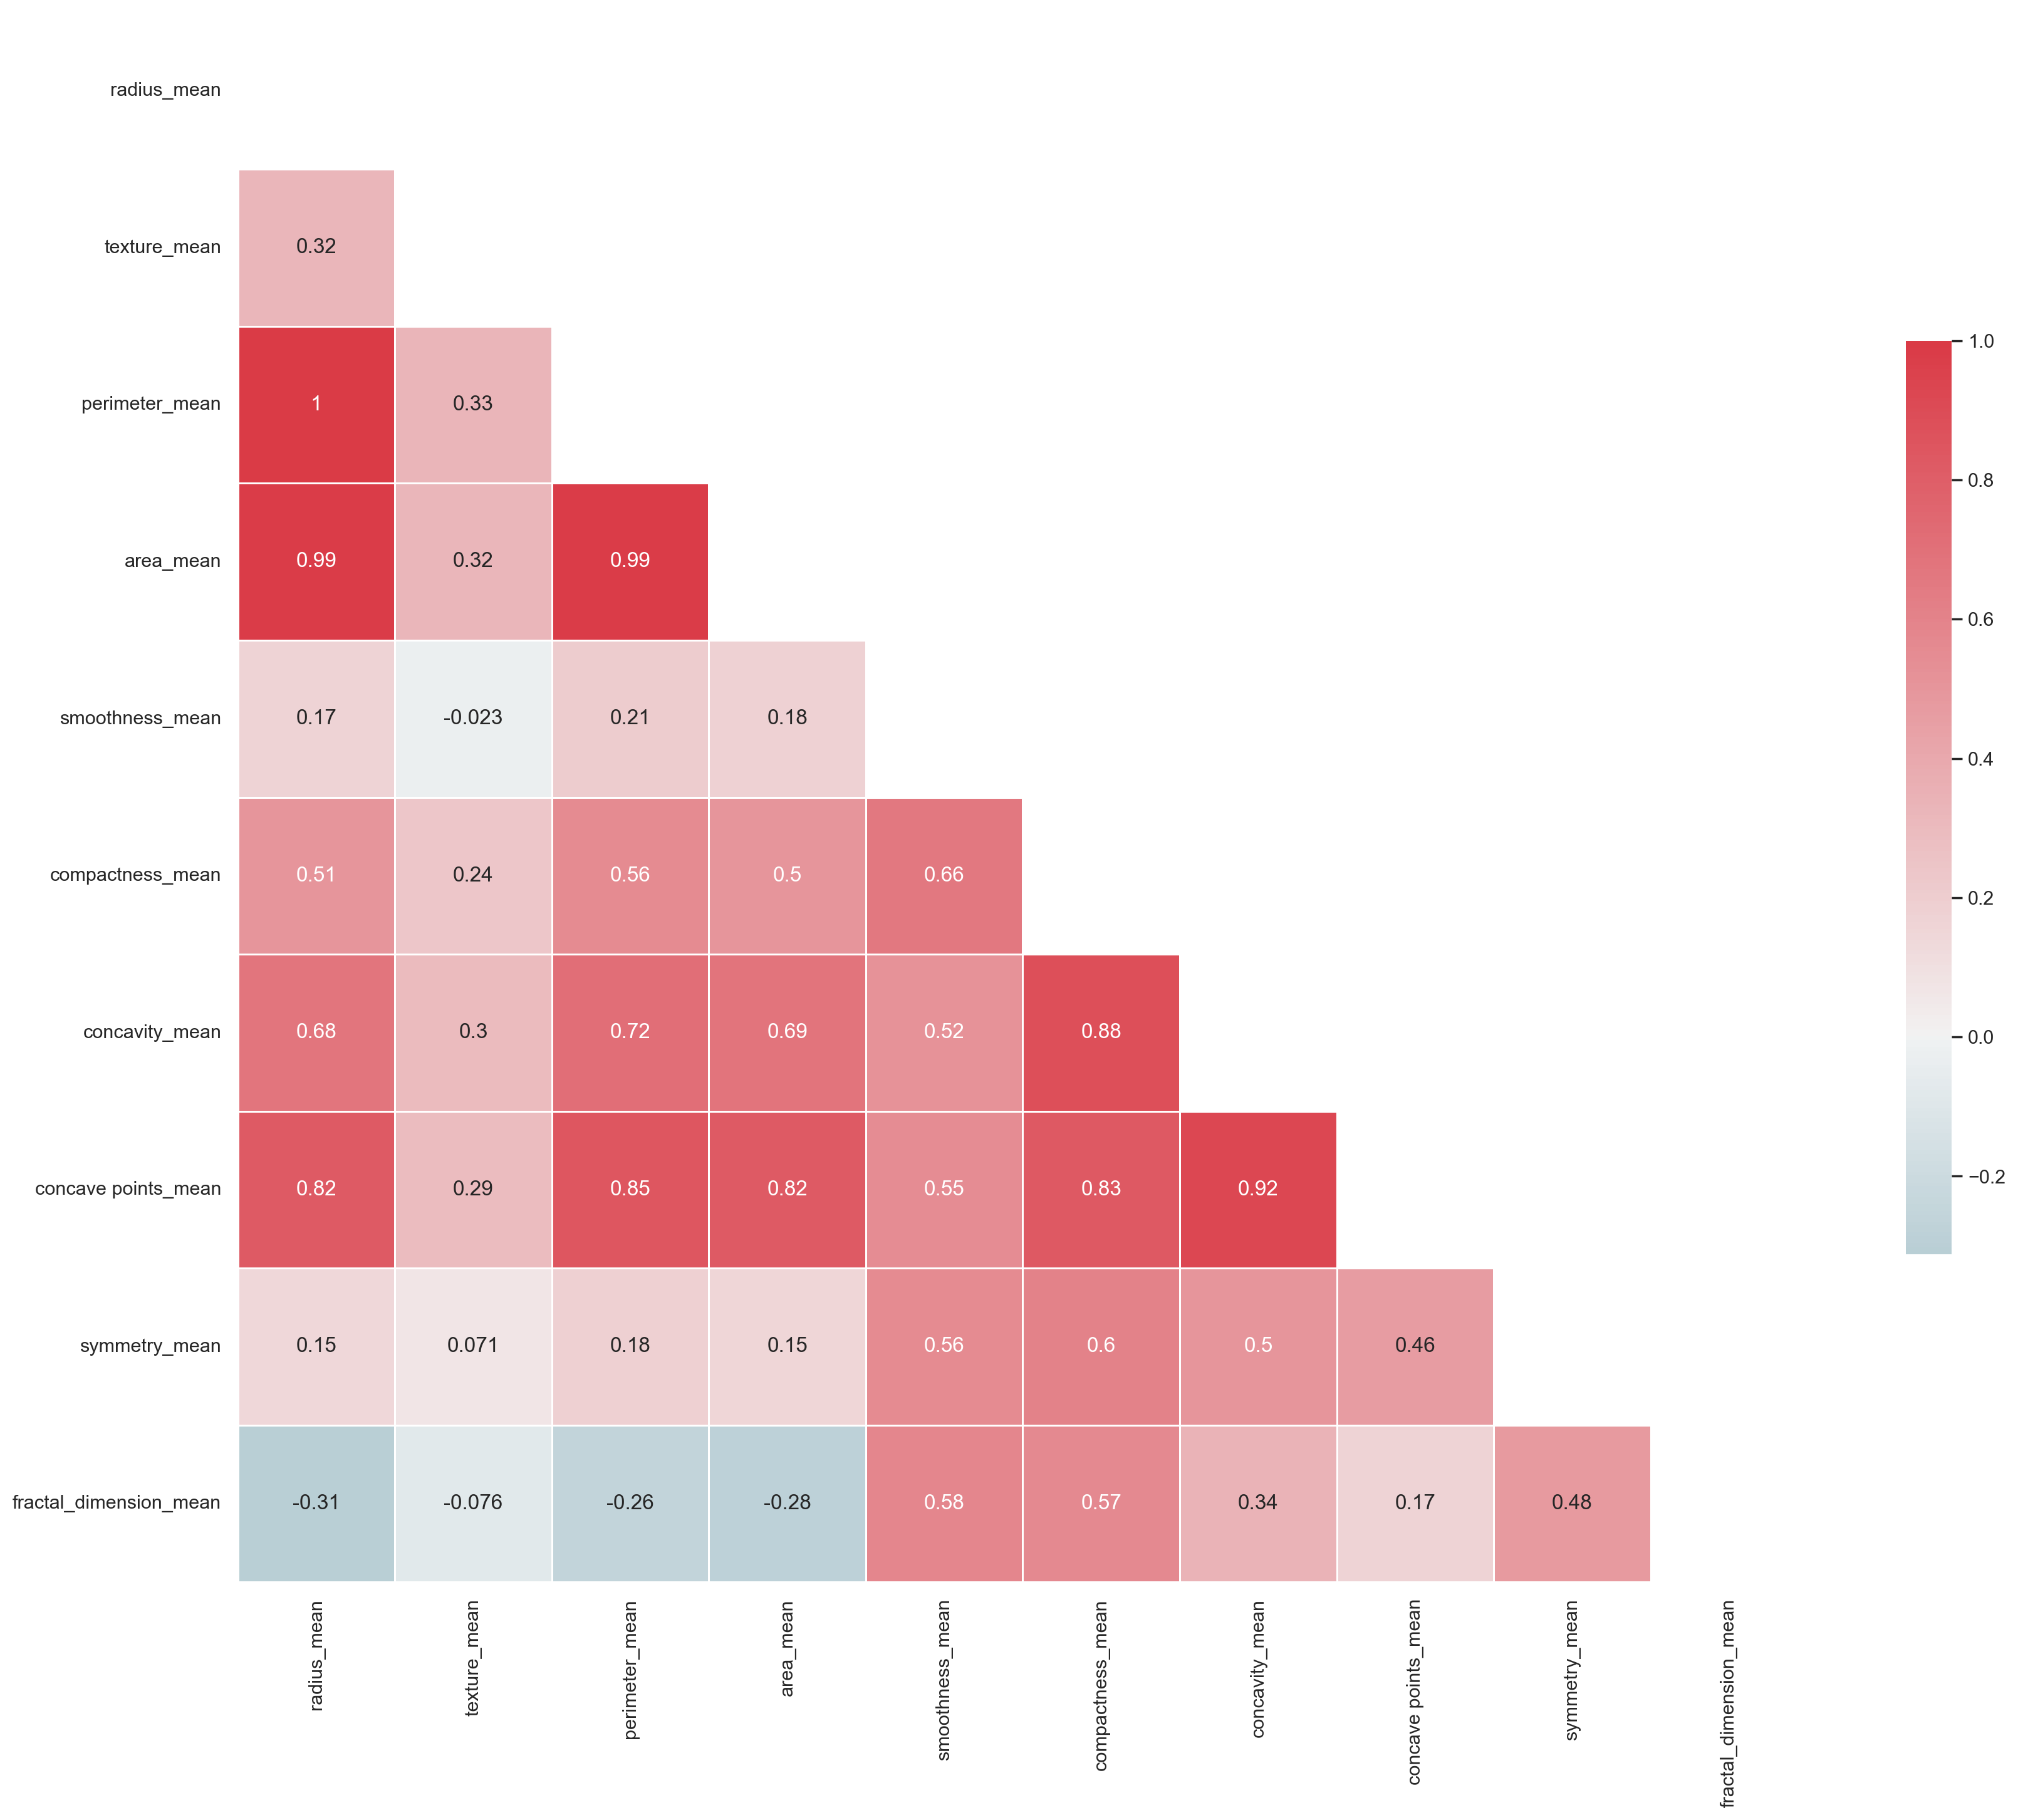

In [33]:
plot_corr_heatmap(selected_breast_cancer)

In [34]:
def find_feature_correlations(df):
    
    """
    Find correlations between df features and convert to a format 
    with one feature1 vs. feature2 correlation value per row 
    
    _Params:_
    
    df: pandas DataFrame, features as columns. All datatypes must be numeric
    
    Returns a pandas DataFrame where a row contains one feature1 vs. feature2 correlation value
    """
    
    # initalise variable lists 
    var1 = []
    var2 = []
    pearsons = []
    pvalues = []
    
    # iterate over generator for tuples of feature combination pairs
    for comb in combinations(df.columns.tolist(), 2):
        
        v1 = comb[0] 
        var1.append(v1) # save feature 1 to list 

        v2 = comb[1]
        var2.append(v2) # save feature 2 to list
        
        p, p_value = stats.pearsonr(df[v1], df[v2]) # get pearson correlation
        pearsons.append(p)
        pvalues.append(p_value)
    
    # Build dataframe of feature1 vs. feature2 pearson correlation
    corr_df = pd.DataFrame({'Feature1': var1,
                            'Feature2': var2,
                            'P': pearsons,
                            'p-value': pvalues})
    
    return corr_df

In [35]:
list(combinations(selected_breast_cancer.columns.tolist(), 2))

[('diagnosis', 'radius_mean'),
 ('diagnosis', 'texture_mean'),
 ('diagnosis', 'perimeter_mean'),
 ('diagnosis', 'area_mean'),
 ('diagnosis', 'smoothness_mean'),
 ('diagnosis', 'compactness_mean'),
 ('diagnosis', 'concavity_mean'),
 ('diagnosis', 'concave points_mean'),
 ('diagnosis', 'symmetry_mean'),
 ('diagnosis', 'fractal_dimension_mean'),
 ('radius_mean', 'texture_mean'),
 ('radius_mean', 'perimeter_mean'),
 ('radius_mean', 'area_mean'),
 ('radius_mean', 'smoothness_mean'),
 ('radius_mean', 'compactness_mean'),
 ('radius_mean', 'concavity_mean'),
 ('radius_mean', 'concave points_mean'),
 ('radius_mean', 'symmetry_mean'),
 ('radius_mean', 'fractal_dimension_mean'),
 ('texture_mean', 'perimeter_mean'),
 ('texture_mean', 'area_mean'),
 ('texture_mean', 'smoothness_mean'),
 ('texture_mean', 'compactness_mean'),
 ('texture_mean', 'concavity_mean'),
 ('texture_mean', 'concave points_mean'),
 ('texture_mean', 'symmetry_mean'),
 ('texture_mean', 'fractal_dimension_mean'),
 ('perimeter_mean

In [36]:
# Use custom function to calculate correlations
cancer_corr = find_feature_correlations(selected_breast_cancer.select_dtypes(np.number))

# Sort rows by descending values of P 
cancer_corr[cancer_corr['P'] > 0.7]

Feature1             Feature2         P        p-value
1        radius_mean       perimeter_mean  0.997855   0.000000e+00
2        radius_mean            area_mean  0.987357   0.000000e+00
6        radius_mean  concave points_mean  0.822529  4.350747e-141
17    perimeter_mean            area_mean  0.986507   0.000000e+00
20    perimeter_mean       concavity_mean  0.716136   1.322967e-90
21    perimeter_mean  concave points_mean  0.850977  1.047656e-160
27         area_mean  concave points_mean  0.823269  1.491019e-141
35  compactness_mean       concavity_mean  0.883121  1.623002e-188
36  compactness_mean  concave points_mean  0.831135  1.240590e-146
39    concavity_mean  concave points_mean  0.921391  6.788791e-235

### 3. Set up the `diagnosis` variable as your target. How many classes are there?

In [37]:
# ANSWER
y = selected_breast_cancer['diagnosis']

### 4. What is the baseline accuracy?

In [38]:
# ANSWER
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

### 5. Choose features to be your predictor variables and set up your X.

In [39]:
# ANSWER
feature_columns = []
excluded_columns = ['diagnosis', 'area_mean', 'radius_mean', 'concavity_mean', 'compact_points_mean']

for column in selected_breast_cancer.columns:
    if column not in excluded_columns:
        feature_columns.append(column)

# list comprehension version:
# feature_columns = [c for c in selected_breast_cancer.columns if c not in excluded_columns]

# Filter for the feature columns
X = selected_breast_cancer[feature_columns]
X.head()

texture_mean  perimeter_mean  smoothness_mean  compactness_mean  \
id                                                                          
842302           10.38          122.80          0.11840           0.27760   
842517           17.77          132.90          0.08474           0.07864   
84300903         21.25          130.00          0.10960           0.15990   
84348301         20.38           77.58          0.14250           0.28390   
84358402         14.34          135.10          0.10030           0.13280   

          concave points_mean  symmetry_mean  fractal_dimension_mean  
id                                                                    
842302                0.14710         0.2419                 0.07871  
842517                0.07017         0.1812                 0.05667  
84300903              0.12790         0.2069                 0.05999  
84348301              0.10520         0.2597                 0.09744  
84358402              0.10430         0.1809                 0.05883

### 6. Fit a `KNeighborsClassifier` with 1 neighbor using the target and predictors.

In [40]:
# ANSWER
from sklearn.neighbors import KNeighborsClassifier

# Make an instance of a KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# fit on the unstandardized data:
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

### 7. Evaluate the accuracy of your model.
- Is it better than baseline?
- Is it legitimate?

In [41]:
# ANSWER
# predict the response values for the observations in X ("test the model")
# store the predicted response values
y_pred_class = knn.predict(X)

# compute classification accuracy
from sklearn import metrics

print(metrics.accuracy_score(y, y_pred_class))

1.0


C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 8. Create a 80-20 train-test-split of your target and predictors. Refit the KNN and assess the accuracy.

In [50]:
# ANSWER
from sklearn.model_selection import train_test_split

# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9385964912280702


C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data.

In [51]:
# ANSWER
# Find rows in X_train
k = X_train.shape[0]

# Fit new KNN model
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

# What is the accuracy when k = number of rows?
print(metrics.accuracy_score(y_test, y_pred_class))

0.6228070175438597


C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### 10. Fit the KNN at values of K from 1 to the number of rows in the training data.
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

In [52]:
# ANSWER
# plot test accuracy by number of neighbors:
list(range(1, X_train.shape[0]+1))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [53]:
# Get accuracy of models with increasing number of neighbors
test_acc = []

for i in range(1, X_train.shape[0]+1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    test_acc.append(knn.score(X_test, y_test))

C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

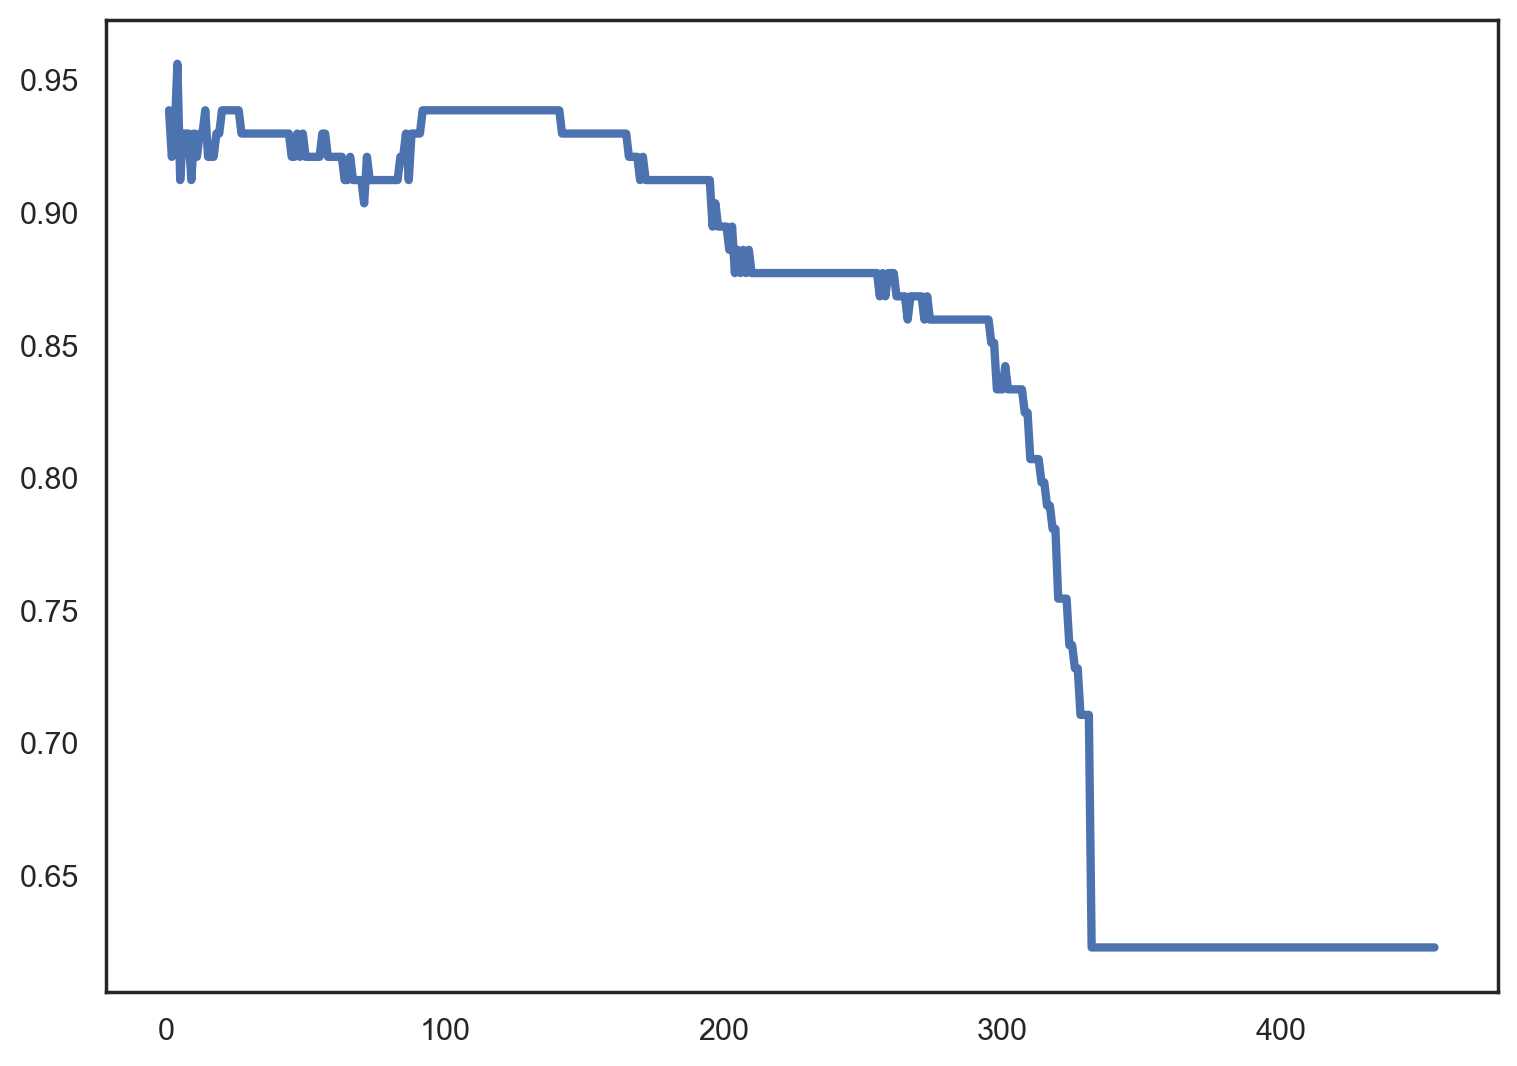

In [54]:
# plot test accuracy by number of neighbors:  

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(1, X_train.shape[0]+1)), test_acc, lw=3.)
plt.show()

### 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds.


In [57]:
# ANSWER
from sklearn.model_selection import cross_val_score

folds = 5
max_neighbors = np.floor(X.shape[0] - X.shape[0]/5.)

print(max_neighbors)

# calculate test accuracy for model fitted with increasing number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc.append(np.mean(cross_val_score(knn, X, y, cv=5)))
    
print(max(test_acc))

455.0


C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

0.9068622884645242


C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

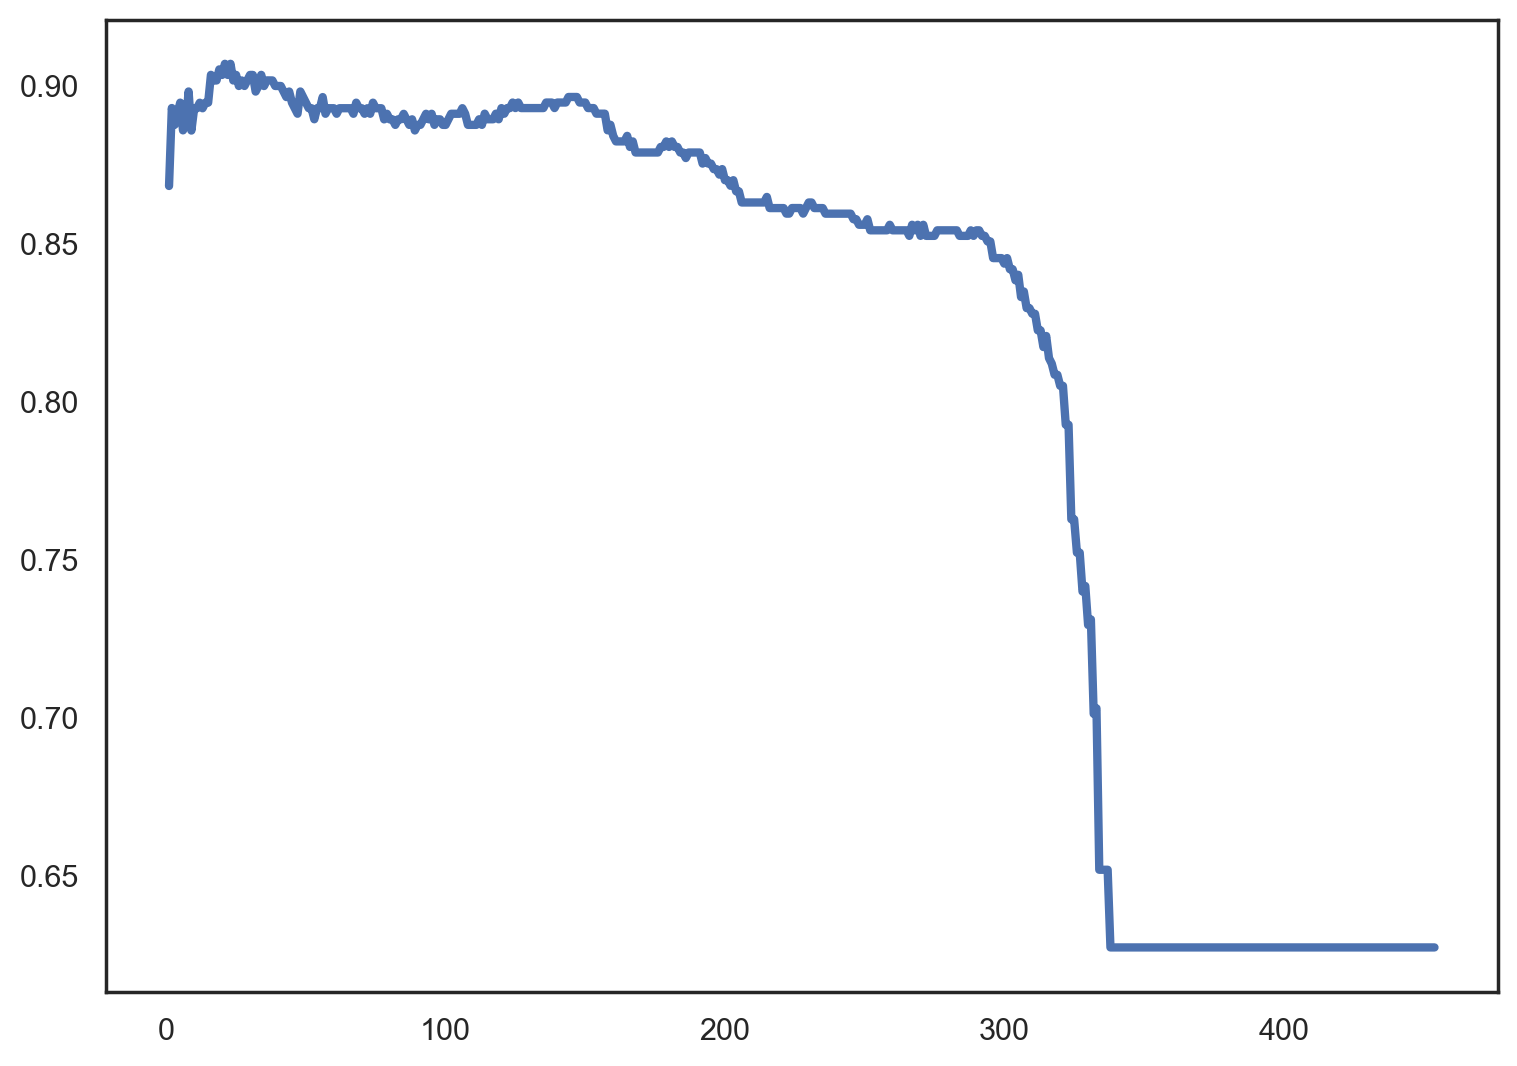

In [58]:
# Plot the accuracy vs. neighbours in KNN model

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(1, int(max_neighbors))), test_acc, lw=3.)
plt.show()

### 12. Standardize the predictor matrix and cross-validate across the different K.
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [59]:
# ANSWER
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [60]:
# ANSWER
# plot test accuracy by number of neighbors:
test_acc_std = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc_std.append(np.mean(cross_val_score(knn, Xs, y, cv=5)))

C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Shivraj\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

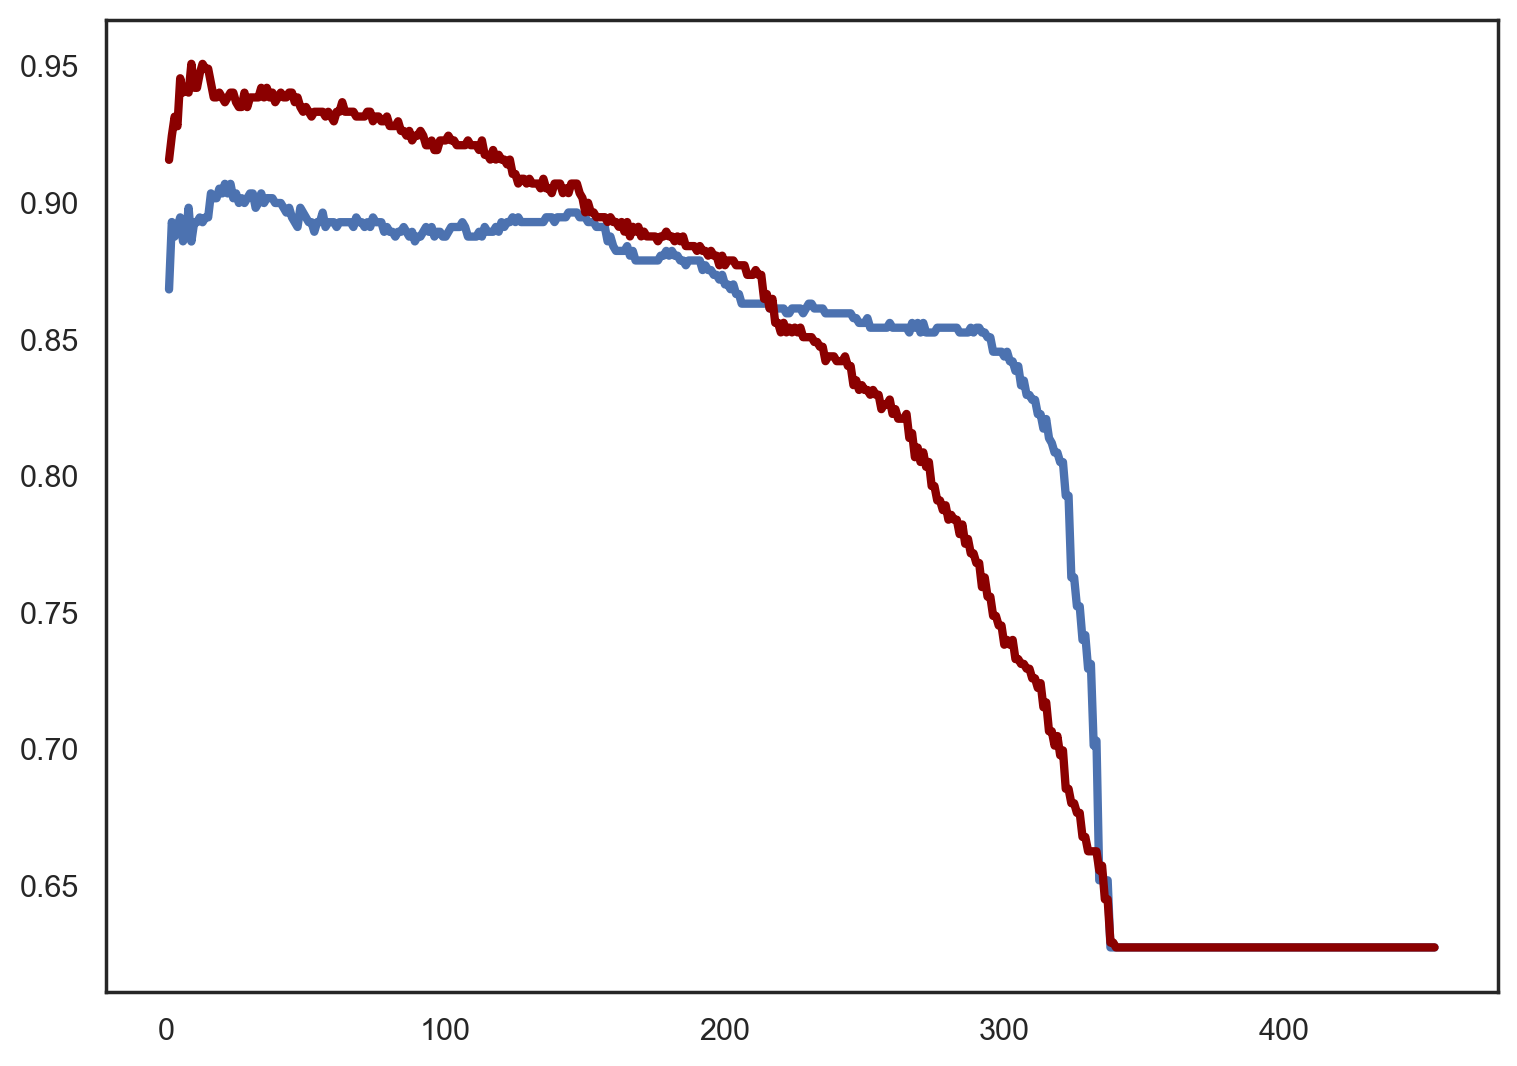

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(1, int(max_neighbors))), test_acc, lw=3.)
ax.plot(list(range(1, int(max_neighbors))), test_acc_std, lw=3., color='darkred')
plt.show()

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



